# Data Quality Control feature engineering notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import json

In [3]:
category = "hat"
filepath = "./raw_data/full%2Fraw%2Fhat.ndjson"
df = pd.read_json(filepath, lines=True)
#print df.groupby(df['countrycode']).count().sort(columns='drawing',ascending=False).head(30)

KeyboardInterrupt: 

In [ ]:
def feature_eng_pt0(df, countries = ['US','BR','RU','KR'], limit = 2500):
    '''
    function: filter dataframe by countries and by total number of stroke (30) and 
    select "limit" number of data points from each country 
    if total number of data points from a country exceeds "limit"
    
    
    input: 
    df = dataframe
    countries = a list of countries
    limit = max number of data points per country
    
    output:
    dataframe that contains datapoints from selected countries
    
    '''
    
    
    #filter dataframe with selected countries
    df_cf = df[(df['countrycode']==countries[0])|(df['countrycode']==countries[1])|\
               (df['countrycode']==countries[2])|(df['countrycode']==countries[3])]
    
    # create feature "stroke_number"
    df_cf['stroke_number']=df_cf['drawing'].str.len()
    
    # US
    df_us = df_cf[(df_cf['countrycode']=='US') & (df_cf['stroke_number'] <= 30)]
    random_US = np.random.choice(list(df_us.index), limit, replace=False)
    df_US = df_us.loc[list(random_US)]
    
    #BR
    if df[df['countrycode']=='BR'].count()[0] > limit:
        df_BR = df_cf[(df_cf['countrycode']=='BR') & (df_cf['stroke_number'] <= 30)]
        random_BR = np.random.choice(list(df_BR.index), limit, replace=False)
        df_BR = df_BR.loc[list(random_BR)]
    else: 
        df_BR = df_cf[(df_cf['countrycode']=='BR') & (df_cf['stroke_number'] <= 30)]

    #RU
    if df[df['countrycode']=='RU'].count()[0] > limit:
        df_RU = df_cf[(df_cf['countrycode']=='RU') & (df_cf['stroke_number'] <= 30)]
        random_RU = np.random.choice(list(df_RU.index), limit, replace=False)
        df_RU = df_RU.loc[list(random_RU)]
    else: 
        df_RU = df_cf[(df_cf['countrycode']=='RU') & (df_cf['stroke_number'] <= 30)]

    #KR
    if df[df['countrycode']=='KR'].count()[0] > limit:
        df_KR = df_cf[(df_cf['countrycode']=='KR') & (df_cf['stroke_number'] <= 30)]
        random_KR = np.random.choice(list(df_KR.index), limit, replace=False)
        df_KR = df_KR.loc[list(random_KR)]
    else: 
        df_KR = df_cf[(df_cf['countrycode']=='KR') & (df_cf['stroke_number'] <= 30)]
    
    return pd.concat([df_US,df_BR,df_RU,df_KR], axis=0)

In [ ]:
def feature_eng_pt1(df_cf):    
    
    '''
    function: 
    feature engineering pt1
    final time = last data points of the time list [int]
    recognized = changing it to boolean [int]
    
    input: 
    df = dataframe 
    
    output:
    dataframe with more features
    '''
    
    #create "final_time"
    final_time = []
    for i in df_cf.index:
        num = df_cf.stroke_number[i]
        final_time.append(df_cf.loc[i,'drawing'][num-1][2][-1])
    df_cf['final_time'] = final_time
    
    #create 'Year','month','day','hour_created' CAUSE DATA LEAKAGE
#     df_cf.timestamp = pd.to_datetime(df_cf.timestamp)
#     df_cf['year'] = df_cf['timestamp'].dt.year
#     df_cf['month'] = df_cf['timestamp'].dt.month
#     df_cf['day'] = df_cf['timestamp'].dt.day
#     df_cf['hour_created'] = df_cf['timestamp'].dt.hour
    
    b_loon = {True: 1, False:0}
    df_cf['recognized'] = df_cf['recognized'].map(b_loon)
    return df_cf

In [ ]:
def feature_eng_pt2(df_cf):
    '''
    function: 
    feature engineering pt2
    X = normalized X range 0 to 1 [list]
    Xmin = minimum value of X [int]
    Xmax = maximum value of X [int]
    Y = normalized Y. normalized using original X value [list]
    Ymin = minimum value of Y [int]
    Ymax = maximum value of Y [int]
    time = time [list]
    time_per_stroke = time spent in each stroke [list]
    dp_per_stroke = total number of data points in a stroke [list]
    stroke_with_max_time = index of stroke that has longest time [int]
    stroke_with_min_time = index of stroke that has shortest time [int]
    std_of_time = standard deviation of time [float]
    ave_datapoints_per_stroke = mean data points per stroke [float]
    total_time_drawing = time spent on drawing [int]
    ave_time_per_stroke = mean time per stroke [float]
    stroke_with_max_dp = index of stroke that has most data points [int]
    stroke_with_min_dp = index of stroke that has least data points [int]
    std_of_dp = standard deviation of data point list [float]
    
    input: 
    df = dataframe 
    
    output:
    dataframe with more features!
    '''
    
    # process:
    # 1. make a list or int
    # 2. store contents of 1. in a new dictionary
    # 3. make new column in your dataframe with 2. dictionary
    
    X = {}
    Xtemp =[]
    Xmin = {}
    Xmax = {}
    Y = {}
    Ytemp =[]
    Ymin = {}
    Ymax ={}
    time = {}
    ttemp =[]
    Tdiff = {}
    Tdifftemp = []
    ttnum_dp = {}
    Tdiffmax = {}
    Tdiffmin = {}
    Tdiffstd = {}
    dpps_temp = []
    dpps = {}
    dp_max = {}
    dp_min = {}
    dp_std = {}
    sumtimeps = {}

    for i in df_cf.index:
        num = df_cf.stroke_number[i]
        for stroke in xrange(num):
            #store X,Y,time of the stroke in a temp list
            Xtemp += (df_cf.loc[i,'drawing'][stroke][0])
            Ytemp += (df_cf.loc[i,'drawing'][stroke][1])
            ttemp += (df_cf.loc[i,'drawing'][stroke][2])
            # calculate the difference between final and initial time of a stroke
            Tdifftemp.append(df_cf.loc[i,'drawing'][stroke][2][-1] - df_cf.loc[i,'drawing'][stroke][2][0])
            # calculate the lengh of the stroke list
            dpps_temp.append(len(df_cf.loc[i,'drawing'][stroke][2]))
        
        # normalizing X and Y
        Xmintemp = np.min(Xtemp)-1
        Xmaxtemp = np.max(Xtemp)+1
        Ymintemp = np.min(Ytemp)-1
        Ymaxtemp = np.max(Ytemp)+1
        Xtemp = (np.array(Xtemp)-np.array([Xmintemp]*len(Xtemp)))/float(Xmaxtemp-Xmintemp)
        Ytemp = (np.array(Ytemp)-np.array([Ymintemp]*len(Ytemp)))/float(Xmaxtemp-Xmintemp)
        Xmax[i] = np.max(Xtemp)
        Xmin[i] = np.min(Xtemp)
        Ymax[i] = np.max(Ytemp)
        Ymin[i] = np.min(Ytemp)
        X[i] = Xtemp
        Y[i] = Ytemp
        
        time[i] = ttemp
        ttnum_dp[i] = len(Xtemp)
        Tdiff[i] = Tdifftemp
        Tdiffmax[i] = np.argmax(Tdifftemp,axis=0)
        Tdiffmin[i] = np.argmin(Tdifftemp,axis=0)
        Tdiffstd[i] = np.std(Tdifftemp)
        dpps[i] = dpps_temp
        dp_max[i] = np.argmax(dpps_temp,axis=0)
        dp_min[i] = np.argmin(dpps_temp,axis=0)
        dp_std[i] = np.std(dpps_temp)
        sumtimeps[i] = sum(Tdifftemp) 
        # initialize temp lists
        Tdifftemp=[]
        Xtemp = []
        Ytemp = []
        ttemp = []
        dpps_temp = []
    # create new features   
    df_cf['total_number_of_datapoints'] = pd.Series(ttnum_dp)
    df_cf['X'] = pd.Series(X)
    df_cf['Xmin'] = pd.Series(Xmin)
    df_cf['Xmax'] = pd.Series(Xmax)
    df_cf['Y'] = pd.Series(Y)
    df_cf['Ymin'] = pd.Series(Ymin)
    df_cf['Ymax'] = pd.Series(Ymax)
    df_cf['time'] = pd.Series(time)
    df_cf['time_per_stroke'] = pd.Series(Tdiff)
    df_cf['dp_per_stroke'] = pd.Series(dpps)
    df_cf['stroke_with_max_time'] = pd.Series(Tdiffmax)
    df_cf['stroke_with_min_time'] = pd.Series(Tdiffmin)
    df_cf['std_of_time'] = pd.Series(Tdiffstd)
    df_cf['ave_datapoints_per_stroke'] = df_cf['total_number_of_datapoints']/(df_cf['stroke_number'])
    df_cf['total_time_drawing'] = pd.Series(sumtimeps)
    df_cf['ave_time_per_stroke'] = df_cf['total_time_drawing']/(df_cf['stroke_number'])
    df_cf['stroke_with_max_dp'] = pd.Series(dp_max)
    df_cf['stroke_with_min_dp'] = pd.Series(dp_min)
    df_cf['std_of_dp'] = pd.Series(dp_std)
    return df_cf

In [ ]:
def feature_eng_pt3(df_cf):
    '''
    function: 
    feature engineering pt2
    slope = slope of a stroke [list]
    direction = radian direction of a stroke [list]
    
    input: 
    df = dataframe 
    
    output:
    dataframe with more features!
    '''
    
    
    slope = {}
    stemp =[]
    direction = {}
    directiontemp = []

    for i in df_cf.index:
        num = df_cf.stroke_number[i]
        for stroke in xrange(num):
            dy = float(df_cf.drawing[i][stroke][1][-1] - df_cf.drawing[i][stroke][1][0])
            dx = float(df_cf.drawing[i][stroke][0][-1] - df_cf.drawing[i][stroke][0][0])
            if dx != 0:
                stemp.append(dy/dx)
            else:
                dx = 0.000001
                stemp.append(dy/dx)
            if dy < 0.0 and dx > 0.0:
                directiontemp.append(2*np.pi + np.arctan(dy/dx))
            elif dy >=0.0 and dx > 0.0:
                directiontemp.append(np.arctan(dy/dx))
            else:
                directiontemp.append(np.pi + np.arctan(dy/dx))
                
        slope[i] = stemp
        direction[i] = directiontemp
        stemp = []
        directiontemp = []
    df_cf['slope'] = pd.Series(slope)
    df_cf['direction'] = pd.Series(direction)
    return df_cf

In [ ]:
def feature_eng_pt4(df_cf):
    for i in xrange(10):
        df_cf['slope_{}'.format(i)] = 0
        df_cf['direction_{}'.format(i)] = 0
        df_cf['time_per_stroke_{}'.format(i)] = 0
        df_cf['dp_per_stroke_{}'.format(i)] = 0
    for ii in xrange(10):
        df_cf['slope_{}_end'.format(10-ii)] = 0
        df_cf['direction_{}_end'.format(10-ii)] = 0
        df_cf['time_per_stroke_{}_end'.format(10-ii)] = 0
        df_cf['dp_per_stroke_{}_end'.format(10-ii)] = 0
        
    for index in df_cf.index:
        if df_cf.stroke_number[index] <=20:
            slopetemp = list(df_cf['slope'][index][:(df_cf.stroke_number[index])]) + [0]*(20-df_cf.stroke_number[index])
            slopetemp = slopetemp[:10] + slopetemp[::-1][:10]
            dirtemp = list(df_cf['direction'][index][:(df_cf.stroke_number[index])]) + [0]*(20-df_cf.stroke_number[index])
            dirtemp = dirtemp[:10] + dirtemp[::-1][:10]
            tptemp = list(df_cf['time_per_stroke'][index][:(df_cf.stroke_number[index])]) + [0]*(20-df_cf.stroke_number[index])
            tptemp = tptemp[:10] + tptemp[::-1][:10]
            dptemp = list(df_cf['dp_per_stroke'][index][:(df_cf.stroke_number[index])]) + [0]*(20-df_cf.stroke_number[index])
            dptemp = dptemp[:10] + dptemp[::-1][:10]
        else:
            slopetemp = list(df_cf['slope'][index][:10]) + list(df_cf['slope'][index][::-1][:10])
            dirtemp = list(df_cf['direction'][index][:10]) + list(df_cf['direction'][index][::-1][:10])
            tptemp = list(df_cf['time_per_stroke'][index][:10]) + list(df_cf['time_per_stroke'][index][::-1][:10])
            dptemp = list(df_cf['dp_per_stroke'][index][:10]) + list(df_cf['dp_per_stroke'][index][::-1][:10])
        for str_n in xrange(10):
            df_cf.loc[index,'slope_{}'.format(str_n)] = slopetemp[str_n]
            df_cf.loc[index,'direction_{}'.format(str_n)] = dirtemp[str_n]
            df_cf.loc[index,'time_per_stroke_{}'.format(str_n)] = tptemp[str_n]
            df_cf.loc[index,'dp_per_stroke_{}'.format(str_n)] = dptemp[str_n]    
            df_cf.loc[index,'slope_{}_end'.format(10-str_n)] = slopetemp[10+str_n]
            df_cf.loc[index,'direction_{}_end'.format(10-str_n)] = dirtemp[10+str_n]
            df_cf.loc[index,'time_per_stroke_{}_end'.format(10-str_n)] = tptemp[10+str_n]
            df_cf.loc[index,'dp_per_stroke_{}_end'.format(10-str_n)] = dptemp[10+str_n]  
    return df_cf

In [ ]:
def feature_eng_pt5(df_cf,category):
    for i in xrange(50):
        df_cf['X_{}'.format(i)] = 0
        df_cf['Y_{}'.format(i)] = 0
    for ii in xrange(50):
        df_cf['X_{}_end'.format(50-ii)] = 0
        df_cf['Y_{}_end'.format(50-ii)] = 0
 
    for index in df_cf.index:
        if df_cf.total_number_of_datapoints[index] <=100:
            Xtemp = list(df_cf['X'][index][:(df_cf.total_number_of_datapoints[index])]) + [0]*(100-df_cf.total_number_of_datapoints[index])
            Xtemp = Xtemp[:50] + Xtemp[::-1][:50]
            Ytemp = list(df_cf['Y'][index][:(df_cf.total_number_of_datapoints[index])]) + [0]*(100-df_cf.total_number_of_datapoints[index])
            Ytemp = Ytemp[:50] + Ytemp[::-1][:50]
        else:
            Xtemp = list(df_cf['X'][index][:50]) + list(df_cf['X'][index][::-1][:50])
            Ytemp = list(df_cf['Y'][index][:50]) + list(df_cf['Y'][index][::-1][:50])
        for str_n in xrange(50):
            df_cf.loc[index,'X_{}'.format(str_n)] = Xtemp[str_n]
            df_cf.loc[index,'Y_{}'.format(str_n)] = Ytemp[str_n]
            df_cf.loc[index,'X_{}_end'.format(50-str_n)] = Xtemp[50+str_n]
            df_cf.loc[index,'Y_{}_end'.format(50-str_n)] = Ytemp[50+str_n]
    df_cf_final = df_cf.drop(['timestamp','drawing','time_per_stroke','dp_per_stroke','slope','direction'], axis=1)
    print df_cf_final.groupby(df_cf_final['countrycode']).count().sort(columns='recognized',ascending=False).head(5)
    df_cf_final.to_pickle("modified_data/{}.pkl".format(category))

In [9]:
def feature_eng_pt_test(df_cf):
    dummies = pd.get_dummies(df_cf['countrycode'], prefix='country', drop_first=True)
    return  df_cf.join(dummies)

In [25]:
df_cf = feature_eng_pt0(df,limit=3300)
df_cf = feature_eng_pt1(df_cf)
df_cf = feature_eng_pt2(df_cf)
df_cf = feature_eng_pt3(df_cf)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
df_cf = feature_eng_pt4(df_cf)
#df_test =feature_eng_pt_test(df_cf)

In [27]:
feature_eng_pt5(df_cf,category)

----------------------------

In [23]:
df_cf_final.head(3)

,countrycode,key_id,recognized,word,stroke_number,final_time,first_X,first_Y,year,month,...,time_per_stroke_27,dp_per_stroke_27,slope_28,direction_28,time_per_stroke_28,dp_per_stroke_28,slope_29,direction_29,time_per_stroke_29,dp_per_stroke_29
61123,US,6374818452602880,1,telephone,16,16927,1223.0,483.0,2017,3,...,0,0,0.0,0.0,0,0,0.0,0.0,0,0
17220,US,5107009823178752,1,telephone,2,6178,789.0,203.0,2017,3,...,0,0,0.0,0.0,0,0,0.0,0.0,0,0
31500,US,6667330371190784,0,telephone,1,5328,746.0,219.0,2017,3,...,0,0,0.0,0.0,0,0,0.0,0.0,0,0


(0, 50)

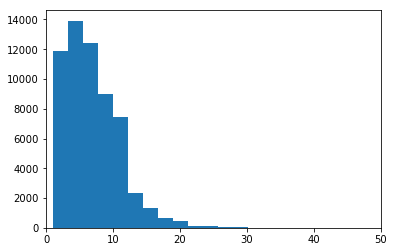

In [117]:
plt.hist(df_cf['stroke_number'],bins=100)
plt.xlim(0,50)

In [121]:
df_cf[df_cf['stroke_number']>30].groupby(df_cf.countrycode).count()

,countrycode,drawing,key_id,recognized,timestamp,word,stroke_number,final_time,first_X,first_Y,...,total_number_of_datapoints,X,Y,time,time_per_stroke,stroke_with_max_time,dp_per_stroke,ave_datapoints_per_stroke,total_time_drawing,ave_time_per_stroke
countrycode,,,,,,,,,,,,,,,,,,,,,
KR,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
RU,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
US,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59


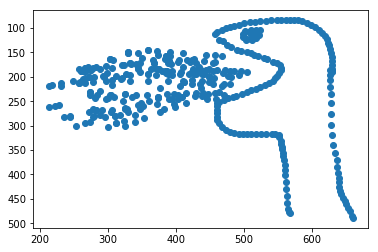

In [81]:
_id = 122125

plt.scatter(df_cf.X[_id],df_cf.Y[_id])
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## testing

In [80]:
columns = [u'recognized',u'stroke_number',u'final_time',u'first_X',u'first_Y',u'total_number_of_datapoints', 
           u'dp_per_stroke',u'stroke_with_max_time',u'stroke_with_min_time',u'std_of_time',u'ave_datapoints_per_stroke',
u'total_time_drawing',u'ave_time_per_stroke',u'stroke_with_max_dp',u'stroke_with_min_dp',u'std_of_dp',u'country_KR',
u'country_RU', u'country_US']

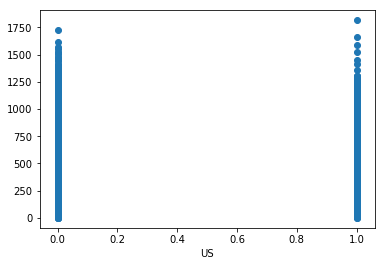

In [28]:
df_t = feature_eng_pt0(df)
df_t1 = feature_eng_pt1(df_t)
df_t2 = feature_eng_pt2(df_t1)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
df_t3 = feature_eng_pt1(df_t)
df_t4 = feature_eng_pt2(df_t3)

In [34]:
df_t2.head(1)

,countrycode,drawing,key_id,recognized,timestamp,word,stroke_number,final_time,first_X,first_Y,...,dp_per_stroke,stroke_with_max_time,stroke_with_min_time,std_of_time,ave_datapoints_per_stroke,total_time_drawing,ave_time_per_stroke,stroke_with_max_dp,stroke_with_min_dp,std_of_dp
99600,US,"[[[473.709014893, 469.682006836, 465.406005859...",4936459909857280,True,2017-03-25 14:30:55.558690,dragon,3,12717,473.709015,75.940002,...,"[91, 17, 38]",0,1,2591.080384,48.666667,11002,3667.333333,0,1,31.137687


In [39]:
df_t4.head(1)

,countrycode,drawing,key_id,recognized,timestamp,word,stroke_number,final_time,first_X,first_Y,...,dp_per_stroke,stroke_with_max_time,stroke_with_min_time,std_of_time,ave_datapoints_per_stroke,total_time_drawing,ave_time_per_stroke,stroke_with_max_dp,stroke_with_min_dp,std_of_dp
99600,US,"[[[473.709014893, 469.682006836, 465.406005859...",4936459909857280,True,2017-03-25 14:30:55.558690,dragon,3,12717,473.709015,75.940002,...,"[91, 17, 38]",0,1,2591.080384,48.666667,11002,3667.333333,0,1,31.137687


(array([  4.04800000e+03,   1.65000000e+03,   0.00000000e+00,
          9.60000000e+02,   0.00000000e+00,   7.03000000e+02,
          0.00000000e+00,   5.43000000e+02,   0.00000000e+00,
          3.86000000e+02,   0.00000000e+00,   3.02000000e+02,
          2.29000000e+02,   0.00000000e+00,   1.53000000e+02,
          0.00000000e+00,   1.05000000e+02,   0.00000000e+00,
          6.80000000e+01,   0.00000000e+00,   4.80000000e+01,
          0.00000000e+00,   4.40000000e+01,   0.00000000e+00,
          2.80000000e+01,   2.30000000e+01,   0.00000000e+00,
          1.50000000e+01,   0.00000000e+00,   1.00000000e+01,
          0.00000000e+00,   8.00000000e+00,   0.00000000e+00,
          8.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
        

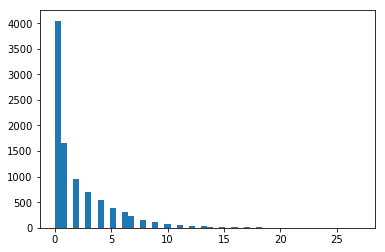

In [34]:
plt.hist(df_test['stroke_with_max_time'], bins = 50)

## rabbit data

In [160]:
df_rb = pd.read_json("./data/full%2Fraw%2Frabbit.ndjson", lines=True)

In [161]:
df_rb = feature_eng_pt1(df_rb)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [162]:
df_rb = feature_eng_pt2(df_rb)

In [164]:
df_rb = feature_eng_pt3(df_rb)

In [172]:
df_rb = feature_eng_pt4(df_rb)

In [166]:
len(df_rb.columns)

31

(0, 50)

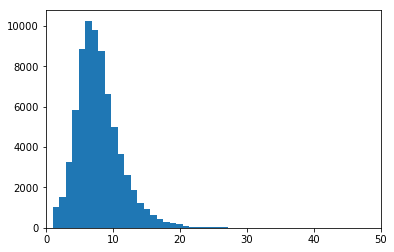

In [9]:
plt.hist(df_rb['stroke_number'],bins=100)
plt.xlim(0,50)

In [180]:
columns = [u'recognized',u'stroke_number',u'final_time',u'first_X',u'first_Y',u'total_number_of_datapoints', 
u'time_per_stroke', u'dp_per_stroke',u'stroke_with_max_time',u'stroke_with_min_time',u'std_of_time',u'ave_datapoints_per_stroke',
u'total_time_drawing',u'ave_time_per_stroke',u'stroke_with_max_dp',u'stroke_with_min_dp',u'std_of_dp',u'country_KR',
u'country_RU', u'country_US']

In [56]:
#df_rb[df_rb['stroke_number']>30].groupby(df_rb.countrycode).count()
df_rb[df_rb['stroke_with_max_time']!=df_rb['stroke_with_max_dp']]

,countrycode,drawing,key_id,recognized,timestamp,word,stroke_number,final_time,first_X,first_Y,...,X,Y,time,time_per_stroke,dp_per_stroke,stroke_with_max_time,ave_datapoints_per_stroke,total_time_drawing,ave_time_per_stroke,stroke_with_max_dp
13,US,"[[[208, 203, 197, 189, 177, 167, 159, 152, 147...",5062797966704640,True,2017-03-04 03:21:37.106800,rabbit,10,16445,208.000000,43.000000,...,"[208, 203, 197, 189, 177, 167, 159, 152, 147, ...","[43, 41, 41, 41, 44, 48, 53, 58, 63, 69, 75, 8...","[0, 61, 80, 93, 109, 126, 143, 162, 178, 193, ...","[744, 288, 795, 495, 1762, 1897, 1295, 1142, 2...","[36, 10, 18, 12, 49, 35, 21, 23, 4, 2]",5,21.000000,8739,873.900000,4
21,US,"[[[688, 677, 669, 659, 646, 632, 617, 603, 590...",5578285914259456,True,2017-03-11 13:37:31.797920,rabbit,7,13374,688.000000,237.000000,...,"[688, 677, 669, 659, 646, 632, 617, 603, 590, ...","[237, 234, 231, 230, 230, 231, 236, 244, 256, ...","[0, 135, 154, 169, 188, 209, 230, 252, 272, 29...","[990, 1935, 1285, 793, 631, 2024, 577]","[43, 61, 47, 3, 8, 18, 9]",5,27.000000,8235,1176.428571,1
22,US,"[[[464, 473.709991455, 480.569976807, 493.1399...",4545618842222592,True,2017-03-02 02:05:51.655060,rabbit,6,5627,464.000000,205.180000,...,"[464, 473.709991455, 480.569976807, 493.139984...","[205.180000305, 197.180000305, 192.039985657, ...","[0, 20, 25, 32, 45, 48, 57, 65, 73, 89, 97, 11...","[530, 638, 561, 408, 369, 644]","[60, 53, 55, 33, 29, 15]",5,40.833333,3150,525.000000,0
31,US,"[[[829, 830, 828, 811, 806, 802, 798, 795, 794...",5140234352197632,True,2017-01-29 04:47:29.837780,rabbit,4,10250,829.000000,541.000000,...,"[829, 830, 828, 811, 806, 802, 798, 795, 794, ...","[541, 536, 531, 512, 509, 503, 489, 483, 477, ...","[0, 112, 136, 218, 304, 328, 398, 412, 426, 45...","[2288, 1905, 2266, 1539]","[53, 45, 91, 36]",0,56.250000,7998,1999.500000,2
54,US,"[[[517, 517, 513, 511, 508, 506, 503, 500, 498...",5859725293912064,True,2017-01-26 18:04:29.019540,rabbit,9,8991,517.000000,325.000000,...,"[517, 517, 513, 511, 508, 506, 503, 500, 498, ...","[325, 318, 309, 303, 297, 291, 284, 278, 271, ...","[0, 56, 73, 81, 89, 97, 105, 116, 121, 129, 13...","[778, 810, 867, 493, 387, 398, 390, 814, 438]","[56, 59, 40, 31, 19, 23, 16, 76, 40]",2,40.000000,5375,597.222222,7
55,US,"[[[253, 251, 253, 257, 262, 266, 272, 277, 283...",6488190376476672,True,2017-01-27 23:58:55.079230,rabbit,11,14765,253.000000,372.000000,...,"[253, 251, 253, 257, 262, 266, 272, 277, 283, ...","[372, 361, 355, 346, 334, 322, 312, 303, 294, ...","[0, 156, 172, 190, 207, 223, 240, 256, 273, 29...","[698, 570, 736, 247, 170, 158, 849, 567, 668, ...","[35, 33, 44, 17, 9, 8, 25, 27, 9, 8, 44]",10,23.545455,6646,604.181818,2
60,US,"[[[635, 637, 640, 643, 646, 655, 663, 672, 677...",4972956092465152,True,2017-03-14 16:54:01.117680,rabbit,9,16169,635.000000,330.000000,...,"[635, 637, 640, 643, 646, 655, 663, 672, 677, ...","[330, 335, 341, 346, 351, 357, 361, 366, 369, ...","[0, 354, 373, 393, 415, 434, 442, 453, 464, 47...","[1561, 1570, 866, 1188, 988, 837, 626, 945, 1324]","[80, 44, 14, 35, 20, 5, 3, 14, 16]",1,25.666667,9905,1100.555556,0
66,BR,"[[[378, 377, 377, 377, 379, 382, 388, 393, 399...",5983467307270144,True,2017-03-24 03:58:57.000580,rabbit,12,19257,378.000000,95.000000,...,"[378, 377, 377, 377, 379, 382, 388, 393, 399, ...","[95, 100, 107, 113, 121, 127, 131, 132, 132, 1...","[0, 49, 101, 149, 176, 233, 270, 305, 352, 399...","[1092, 1126, 958, 1791, 248, 281, 128, 90, 109...","[21, 21, 18, 18, 4, 4, 2, 2, 4, 2, 2, 8]",3,8.833333,7456,621.333333,0
73,US,"[[[617, 614, 613, 610, 608, 606, 607, 609, 614...",6413665089617920,False,2017-03-19 15:00:01.426760,rabbit,8,18547,617.000000,302.000000,...,"[617, 614, 613, 610, 608, 606, 607, 609, 614, ...","[302, 307, 312, 317, 322, 327, 332, 337, 342, ...","[0, 735, 1196, 1255, 1343, 1461, 1609, 1679, 1...","[3380, 1210, 1299, 2199, 1488, 570, 2438, 67]","[28, 18, 23, 35, 4, 5, 16, 2]",0,16.375000,12651,1581.375000,3
79,US,"[[[868, 863, 857, 852, 84

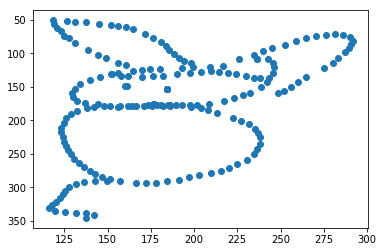

In [123]:
_id = 0
plt.scatter(df_rb.X[_id],df_rb.Y[_id])
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146310110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x173a03750>]], dtype=object)

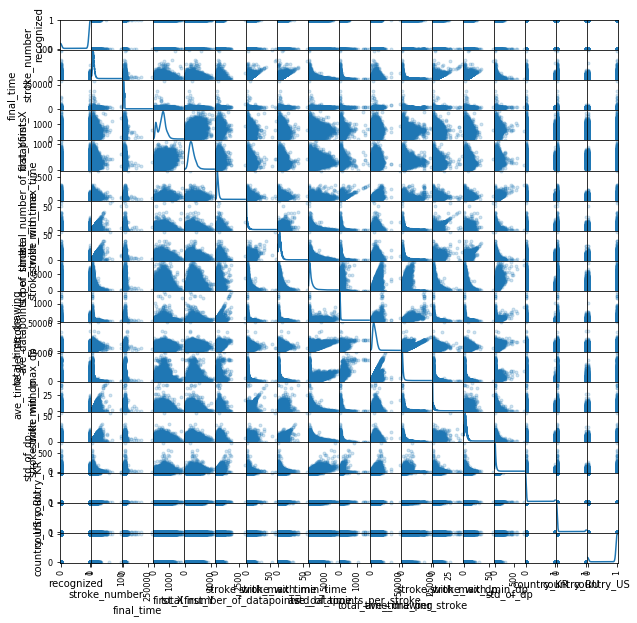

In [181]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df_rb[columns], alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:
for i in columns:
    if i != 'stroke_number':
        plt.hist(df_rb.stroke_number,df_rb[i])

KeyboardInterrupt: 

In [ ]:
df_rb.index

In [156]:
np.std(df_rb.dp_per_stroke[0])

18.49991658306185

In [127]:
np.arctan(.46611)

0.43616994552358651

## mountain data

In [21]:
df_mt = pd.read_json("./data/full%2Fraw%2Fmountain.ndjson", lines=True)

In [22]:
df_mt = feature_eng_pt1(df_mt)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [23]:
df_mt = feature_eng_pt2(df_mt)

(0, 50000)

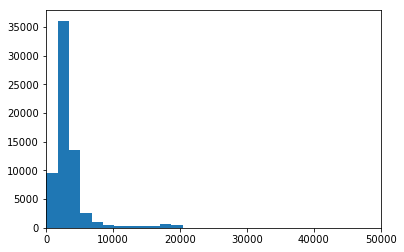

In [54]:
plt.hist(df_mt['final_time'],bins=100)
plt.xlim(0,50000)

In [55]:
df_mt[df_mt['final_time']> 30000]

,countrycode,drawing,key_id,recognized,timestamp,word,stroke_number,final_time,first_X,first_Y,...,X,Y,time,time_per_stroke,dp_per_stroke,stroke_with_max_time,ave_datapoints_per_stroke,total_time_drawing,ave_time_per_stroke,stroke_with_max_dp
7821,RU,"[[[728, 728, 727, 727, 727, 727, 727, 727, 727...",5307337197748224,False,2017-03-06 18:57:37.640920,mountain,3,56300,728.0,100.0,...,"[728, 728, 727, 727, 727, 727, 727, 727, 727, ...","[100, 105, 111, 117, 122, 127, 133, 141, 147, ...","[0, 43, 57, 66, 73, 78, 84, 92, 98, 102, 108, ...","[3289, 1158, 2216]","[209, 25, 110]",0,114.666667,6663,2221.000000,0
10480,US,"[[[410, 410], [832, 832], [0, 276]], [[124, 12...",5860767087722496,True,2017-03-02 16:54:03.600090,mountain,2,169810,410.0,832.0,...,"[410, 410, 124, 123, 124, 128, 136, 144, 153, ...","[832, 832, 638, 631, 625, 617, 604, 589, 572, ...","[0, 276, 166806, 166826, 166841, 166862, 16687...","[276, 3004]","[2, 152]",1,77.000000,3280,1640.000000,1
19720,US,"[[[558, 563, 570, 583, 600, 620, 657, 705, 752...",4512029765271552,False,2017-03-23 14:48:44.449450,mountain,2,34541,558.0,418.0,...,"[558, 563, 570, 583, 600, 620, 657, 705, 752, ...","[418, 416, 415, 413, 409, 409, 414, 419, 433, ...","[0, 206, 213, 224, 233, 244, 253, 263, 274, 28...","[6725, 3673]","[299, 129]",0,214.000000,10398,5199.000000,0
28468,US,"[[[406, 400, 398, 396, 395, 401, 415, 422, 440...",5115335151714304,True,2017-01-30 19:34:13.641240,mountain,4,33104,406.0,500.0,...,"[406, 400, 398, 396, 395, 401, 415, 422, 440, ...","[500, 494, 484, 457, 425, 383, 312, 287, 223, ...","[0, 62, 71, 89, 106, 135, 145, 164, 176, 179, ...","[3636, 3076, 369, 223]","[188, 106, 14, 8]",0,79.000000,7304,1826.000000,0
57772,US,"[[[84, 84, 84, 88, 93, 95, 95, 95, 95, 93, 88,...",5917413012930560,True,2017-01-23 17:57:04.668780,mountain,2,33529,84.0,546.0,...,"[84, 84, 84, 88, 93, 95, 95, 95, 95, 93, 88, 8...","[546, 555, 560, 565, 565, 572, 584, 597, 609, ...","[0, 45, 63, 96, 130, 162, 178, 195, 212, 229, ...","[736, 2580]","[33, 111]",1,72.000000,3316,1658.000000,1
61405,KR,"[[[432, 430], [200, 200], [1, 113]], [[455, 46...",4994083372138496,False,2017-03-19 07:18:30.624120,mountain,13,37995,432.0,200.0,...,"[432, 430, 455, 460.609008789, 466.191009521, ...","[200, 200, 110, 107.79699707, 106.761993408, 1...","[1, 113, 990, 1023, 1042, 1065, 1083, 1114, 11...","[112, 434, 625, 325, 1337, 340, 556, 1197, 724...","[2, 18, 17, 3, 9, 4, 7, 11, 6, 4, 6, 8, 7]",4,7.846154,7780,598.461538,1
85161,US,"[[[315, 317, 322, 330, 337, 346, 353, 361, 370...",6119176110342144,False,2017-03-12 17:21:33.971690,mountain,42,40590,315.0,412.0,...,"[315, 317, 322, 330, 337, 346, 353, 361, 370, ...","[412, 404, 393, 378, 361, 339, 318, 294, 269, ...","[0, 83, 100, 116, 133, 150, 166, 183, 200, 216...","[1234, 1051, 1349, 1017, 868, 299, 249, 216, 6...","[59, 51, 40, 45, 17, 5, 6, 5, 16, 1, 2, 2, 2, ...",15,11.404762,14802,352.428571,0
99519,US,"[[[335, 340, 347, 358, 381, 389, 404, 415, 429...",4971854970224640,False,2017-03-17 20:40:17.885710,mountain,20,43251,335.0,381.0,...,"[335, 340, 347, 358, 381, 389, 404, 415, 429, ...","[381, 381, 378, 372, 361, 357, 347, 341, 333, ...","[0, 152, 163, 178, 189, 193, 206, 209, 222, 22...","[6773, 2391, 1180, 1484, 1348, 991, 1284, 912,...","[190, 58, 32, 27, 31, 27, 21, 26, 39, 50, 3, 2...",0,37.200000,26219,1310.950000,0
110136,KR,"[[[811, 812, 850, 845, 842, 840, 839, 838, 839...",4654043496448000,False,2017-03-19 04:42:13.347550,mountain,12,31046,811.0,279.0,...,"[811, 812, 850, 845, 842, 840, 839, 838, 839, ...","[279, 272, 320, 327, 333, 342, 349, 357, 363, ...","[0, 46, 266, 271, 278, 286, 294, 302, 312, 325...","[393, 112, 540, 635, 1417, 240, 742, 377, 530,...","[13, 2, 11, 63, 44, 24, 86, 32, 34, 16, 18, 8]",4,29.250000,6016,501.333333,6
127506,US,"[[[362, 367, 372, 377, 382, 387, 393, 399, 404...",6691203762356224,True,2017-03-26 04:03:55.392720,mountain,7,31824,362.0,498.0,...,"[362, 367, 372, 377, 382, 387, 393, 399, 404, ...","[498, 499,

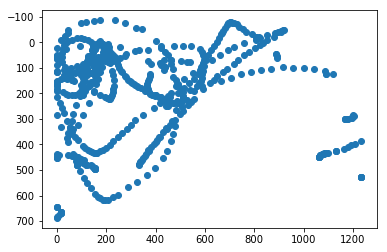

In [52]:
_id = 119672
plt.scatter(df_mt.X[_id],df_mt.Y[_id])
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## other

In [20]:
group_nation = df[(df['recognized']==True)].groupby(df['countrycode']).count()

NameError: name 'df' is not defined

In [ ]:
group_nation.sort(columns='drawing',ascending=False).head(15)

In [44]:
df_rabbit = pd.read_json("./data/full%2Fraw%2Frabbit.ndjson", lines=True)

In [45]:
df_mountain = pd.read_json("./data/full%2Fraw%2Fmountain.ndjson", lines=True)

In [46]:
df_cellphone = pd.read_json("./data/full%2Fraw%2Fcell phone.ndjson", lines=True)

In [59]:
gn_rabbit = df_rabbit[(df_rabbit['recognized']==True)].groupby(df_rabbit['countrycode']).count()
gn_rabbit.sort(columns='drawing',ascending=False).head(30)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,countrycode,drawing,key_id,recognized,timestamp,word
countrycode,,,,,,
US,53302,53302,53302,53302,53302,53302
GB,9208,9208,9208,9208,9208,9208
CA,4737,4737,4737,4737,4737,4737
DE,4731,4731,4731,4731,4731,4731
RU,3415,3415,3415,3415,3415,3415
AU,3062,3062,3062,3062,3062,3062
KR,2918,2918,2918,2918,2918,2918
BR,2678,2678,2678,2678,2678,2678
FI,2456,2456,2456,2456,2456,2456


In [61]:
gn_mt = df_mountain[(df_mountain['recognized']==True)].groupby(df_mountain['countrycode']).count()
gn_mt.sort(columns='drawing',ascending=False).head(30)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,countrycode,drawing,key_id,recognized,timestamp,word
countrycode,,,,,,
US,56150,56150,56150,56150,56150,56150
GB,9035,9035,9035,9035,9035,9035
DE,4234,4234,4234,4234,4234,4234
CA,4229,4229,4229,4229,4229,4229
RU,2718,2718,2718,2718,2718,2718
BR,2586,2586,2586,2586,2586,2586
AU,2581,2581,2581,2581,2581,2581
FI,2126,2126,2126,2126,2126,2126
SE,2043,2043,2043,2043,2043,2043


In [62]:
gn_cp = df_cellphone[(df_cellphone['recognized']==True)].groupby(df_cellphone['countrycode']).count()
gn_cp.sort(columns='drawing',ascending=False).head(30)

/Users/keisukeirie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,countrycode,drawing,key_id,recognized,timestamp,word
countrycode,,,,,,
US,48232,48232,48232,48232,48232,48232
GB,8302,8302,8302,8302,8302,8302
CA,4035,4035,4035,4035,4035,4035
DE,3714,3714,3714,3714,3714,3714
BR,2726,2726,2726,2726,2726,2726
AU,2606,2606,2606,2606,2606,2606
RU,2548,2548,2548,2548,2548,2548
SE,2124,2124,2124,2124,2124,2124
IT,2005,2005,2005,2005,2005,2005


In [81]:
df_rabbit['drawing'][0][0][2]

[0,
 116,
 152,
 187,
 192,
 203,
 217,
 236,
 278,
 287,
 318,
 351,
 387,
 420,
 454,
 488,
 522,
 557,
 590,
 608,
 624,
 644,
 658,
 681,
 694,
 711,
 728,
 745,
 763,
 796,
 813,
 829,
 851,
 885,
 897,
 916,
 938,
 953,
 988,
 1019,
 1053,
 1088]

In [94]:
test = np.array(df_mountain['timestamp'][(df_mountain['countrycode']=='US')])

In [221]:
rrr ={}

In [223]:
rrr[1] = [0,2,3,4,5]

In [243]:
rr = {}
rr[1] = [7,6,8,5]

In [262]:
rrr[1].append(rr[1])

In [264]:
aaa = ([1,1,1,1,1],[3,4,5])

[0, 2, 3, 4, 5, [7, 6, 8, 5], 7, 6, 8, 5]

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[136, 119, 71, 53, 9, 0, 21, 64, 67, 65, 75,...",5795934136958976,True,2017-03-26 18:11:00.449190,dragon
1,BE,"[[[5, 30, 40, 73, 83, 87, 87, 70, 44, 36, 6, 2...",5715354980450304,True,2017-03-28 21:42:33.092960,dragon
2,US,"[[[109, 102, 101, 105, 128, 154, 168, 177, 210...",4739868104065024,True,2017-01-27 16:26:18.424590,dragon
3,NO,"[[[28, 0, 12, 29, 26, 13, 55, 80, 83, 83, 101,...",5114380171608064,True,2017-03-21 18:37:03.019580,dragon
4,HU,"[[[24, 44], [24, 21]], [[24, 47], [35, 33]], [...",5819432574124032,True,2017-03-27 14:02:17.215920,dragon
5,PH,"[[[128, 122, 104, 86, 82, 76, 74], [24, 29, 30...",6289533857431552,True,2017-03-27 04:02:42.038860,dragon
6,US,"[[[166, 178, 223, 243, 233, 229, 220, 209, 196...",5794938933477376,True,2017-01-26 01:17:59.183880,dragon
7,FI,"[[[105, 125, 147, 163, 194, 212, 214, 209, 199...",6472461400932352,True,2017-01-29 16:34:49.674710,dragon
8,AU,"[[[197, 193, 181, 163, 142, 131, 126, 83, 72, ...",6050774343745536,True,2017-03-28 12:42:45.201080,dragon
9,GB,"[[[121, 93, 67, 62, 64, 76, 90, 110, 134, 149,...",6308536726323200,True,2017-01-28 00:18:53.782640,dragon


In [86]:
(np.array([1,2,3,4,5,6,7])-np.array([5]*7))/float(2)

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])